# Installing and importing necessary libraries

In [1]:
!pip install imbalanced-learn -q
!pip install ucimlrepo -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, silhouette_score,
    roc_curve, precision_recall_curve # Added for direct plotting
)
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo
# Removed: import scikitplot as skplt # Import scikit-plot
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Loading and exploring the dataset

In [4]:
# Fetch dataset directly from UCI
bank_marketing = fetch_ucirepo(id=222)

In [5]:
# Data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

In [6]:
# Combine features and target for initial exploration
data = pd.concat([X, y], axis=1)

In [7]:
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
data.head()

Dataset Shape: (45211, 17)

First 5 rows:


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [8]:
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [9]:
print("\nMissing Values:")
data.isnull().sum()


Missing Values:


,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


In [10]:
print("Missing Values Summary:")
missing_summary = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0])

print(f"\nTotal missing values: {data.isnull().sum().sum()}")
print(f"Percentage of data missing: {(data.isnull().sum().sum() / (data.shape[0] * data.shape[1])) * 100:.2f}%")

Missing Values Summary:
           Missing Count  Missing Percentage
job                  288            0.637013
education           1857            4.107407
contact            13020           28.798301
poutcome           36959           81.747805

Total missing values: 52124
Percentage of data missing: 6.78%


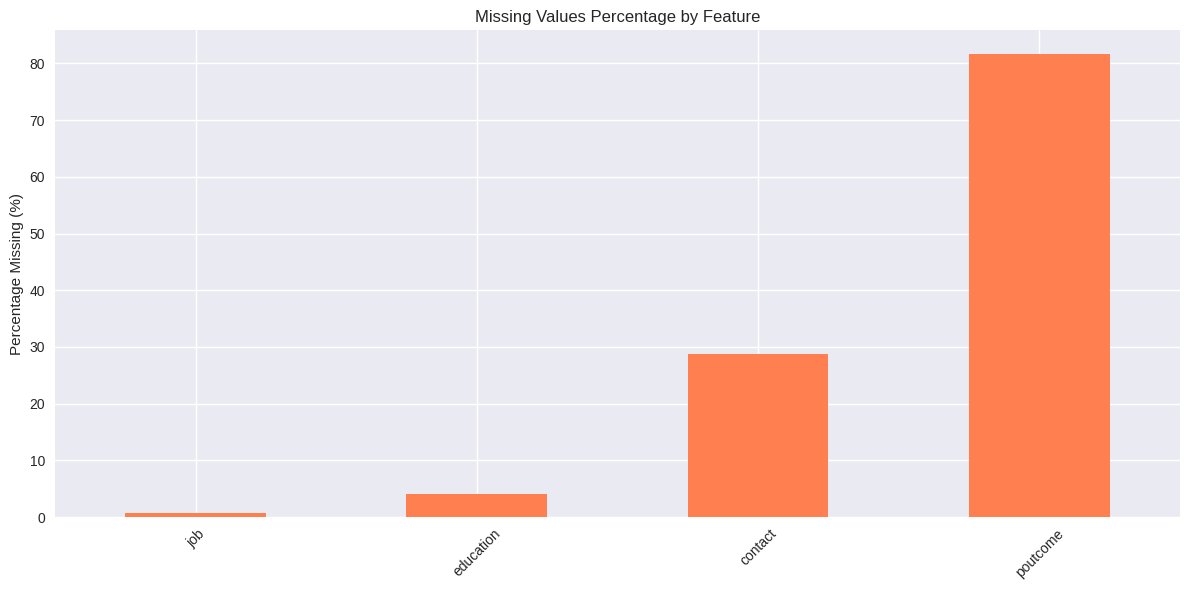

In [11]:
# Visualize missing values
plt.figure(figsize=(12, 6))
missing_plot = missing_df[missing_df['Missing Count'] > 0]['Missing Percentage']
if len(missing_plot) > 0:
    missing_plot.plot(kind='bar', color='coral')
    plt.title('Missing Values Percentage by Feature')
    plt.ylabel('Percentage Missing (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset!")

#Handling missing values

In [12]:
# Create a copy for preprocessing
df = data.copy()

In [13]:
print("Original data shape:", df.shape)

# Define strategies for different types of missing values
missing_strategies = {}

Original data shape: (45211, 17)


In [14]:
# For categorical columns with missing values
categorical_cols_with_missing = ['job', 'education', 'contact', 'poutcome']
for col in categorical_cols_with_missing:
    if col in df.columns and df[col].isnull().sum() > 0:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        print(f"\n{col}: {missing_count} missing values ({missing_pct:.2f}%)")

        # For low missing percentage, use mode imputation
        if missing_pct < 5:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
            missing_strategies[col] = f'Mode imputation: {mode_value}'
            print(f"  -> Filled with mode: {mode_value}")
        else:
            # For high missing percentage, create "Unknown" category
            df[col].fillna('unknown', inplace=True)
            missing_strategies[col] = 'Created "unknown" category'
            print(f'  -> Filled with "unknown"')

print("\nMissing values handling strategies:")
for col, strategy in missing_strategies.items():
    print(f"{col}: {strategy}")


job: 288 missing values (0.64%)
  -> Filled with mode: blue-collar

education: 1857 missing values (4.11%)
  -> Filled with mode: secondary

contact: 13020 missing values (28.80%)
  -> Filled with "unknown"

poutcome: 36959 missing values (81.75%)
  -> Filled with "unknown"

Missing values handling strategies:
job: Mode imputation: blue-collar
education: Mode imputation: secondary
contact: Created "unknown" category
poutcome: Created "unknown" category


In [15]:
print(f"\nMissing values after handling: {df.isnull().sum().sum()}")
print("Data shape after handling missing values:", df.shape)


Missing values after handling: 0
Data shape after handling missing values: (45211, 17)


# Comprehensive Data Exploration

In [16]:
print("Target Variable Distribution:")
print(df['y'].value_counts())
print(f"Subscription Rate: {df['y'].value_counts()['yes']/len(df)*100:.2f}%")

Target Variable Distribution:
y
no     39922
yes     5289
Name: count, dtype: int64
Subscription Rate: 11.70%


In [17]:
print("\nBasic Statistics for Numerical Features:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols].describe()


Basic Statistics for Numerical Features:


,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [18]:
print("\nCategorical Features Summary:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    if 'unknown' in df[col].value_counts():
        unknown_pct = (df[col].value_counts()['unknown'] / len(df)) * 100
        print(f"  Unknown values: {df[col].value_counts()['unknown']} ({unknown_pct:.2f}%)")


Categorical Features Summary:

job:
job
blue-collar      10020
management        9458
technician        7597
admin.            5171
services          4154
retired           2264
self-employed     1579
entrepreneur      1487
unemployed        1303
housemaid         1240
student            938
Name: count, dtype: int64

marital:
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

education:
education
secondary    25059
tertiary     13301
primary       6851
Name: count, dtype: int64

default:
default
no     44396
yes      815
Name: count, dtype: int64

housing:
housing
yes    25130
no     20081
Name: count, dtype: int64

loan:
loan
no     37967
yes     7244
Name: count, dtype: int64

contact:
contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64
  Unknown values: 13020 (28.80%)

month:
month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep     

# Advanced Data Visualization for EDA

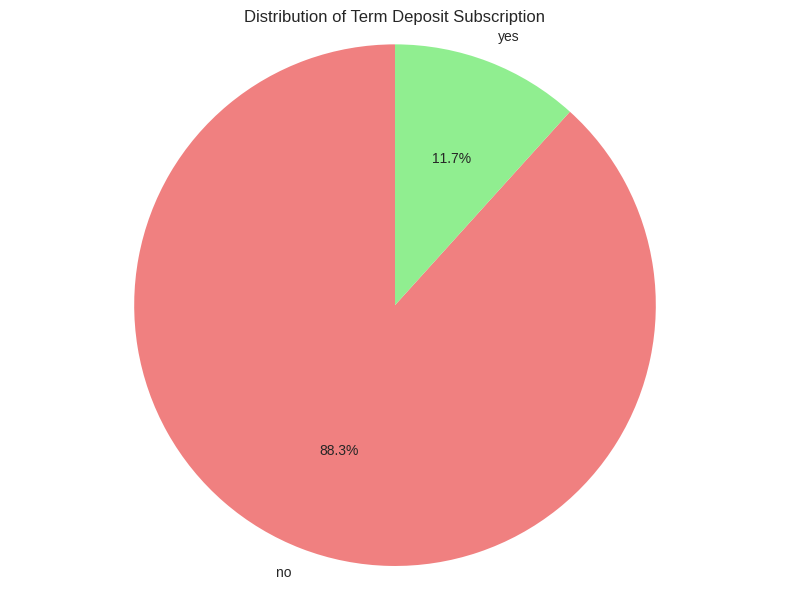

In [19]:
# Target distribution
plt.figure(figsize=(8, 6)) # Create a new figure for this plot
target_counts = df['y'].value_counts()
plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
              colors=['lightcoral', 'lightgreen'], startangle=90)
plt.title('Distribution of Term Deposit Subscription')
plt.axis('equal') # Ensure pie chart is circular
plt.tight_layout()
plt.show() # Display this plot

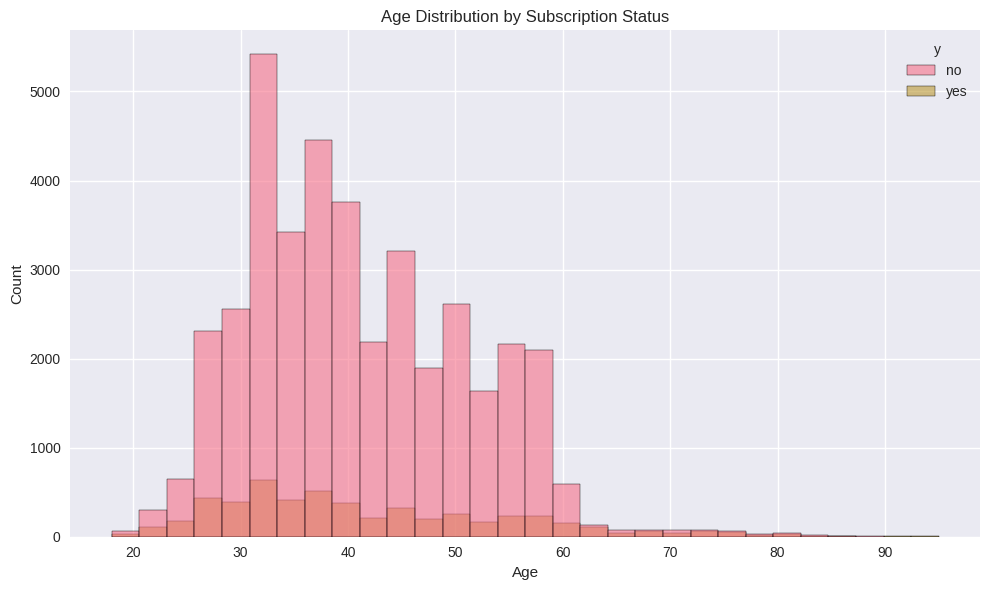

In [20]:
# Age distribution by subscription
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='y', bins=30, alpha=0.6)
plt.title('Age Distribution by Subscription Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show() # Display this plot

<Figure size 1200x700 with 0 Axes>

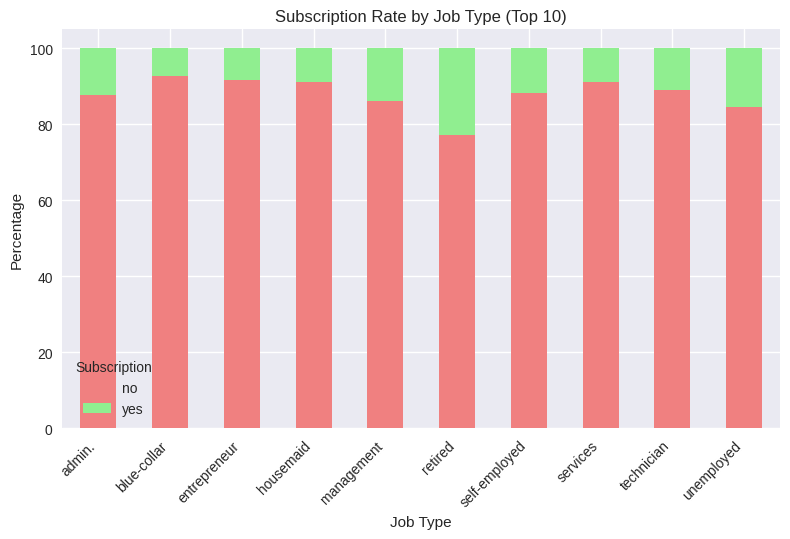

In [21]:
# Job distribution (top 10 jobs)
plt.figure(figsize=(12, 7))
top_jobs = df['job'].value_counts().head(10).index
job_subscription = pd.crosstab(df[df['job'].isin(top_jobs)]['job'], df[df['job'].isin(top_jobs)]['y'], normalize='index') * 100
job_subscription.plot(kind='bar', stacked=True, color=['lightcoral', 'lightgreen'])
plt.title('Subscription Rate by Job Type (Top 10)')
plt.xlabel('Job Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Subscription')
plt.tight_layout()
plt.show()

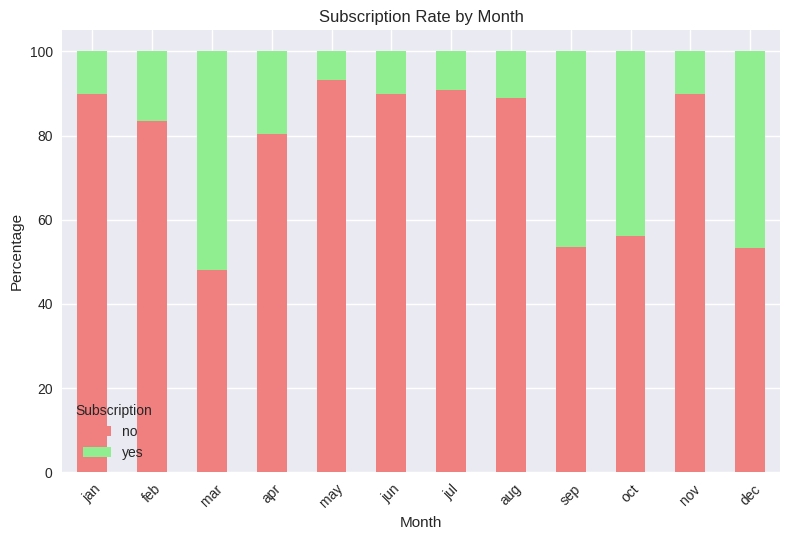

In [22]:
# Month vs subscription
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
month_subscription = pd.crosstab(df['month'], df['y'], normalize='index') * 100
month_subscription.plot(kind='bar', stacked=True, color=['lightcoral', 'lightgreen'])
plt.title('Subscription Rate by Month')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Subscription')
plt.tight_layout()
plt.show()

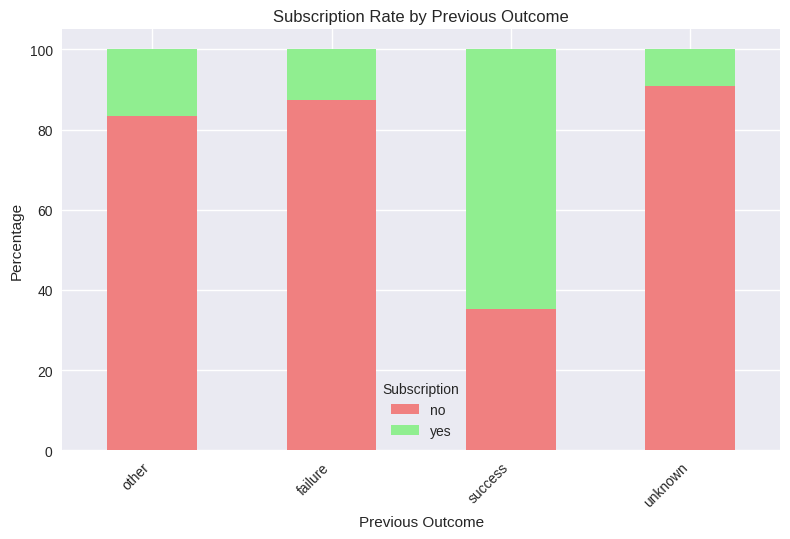

In [23]:
# Previous outcomes
previous_subscription = pd.crosstab(df['poutcome'], df['y'], normalize='index') * 100
previous_subscription = previous_subscription.reindex(previous_subscription.sum(axis=1).sort_values(ascending=False).index)
previous_subscription.plot(kind='bar', stacked=True, color=['lightcoral', 'lightgreen'])
plt.title('Subscription Rate by Previous Outcome')
plt.xlabel('Previous Outcome')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Subscription')
plt.tight_layout()
plt.show() # Display this plot

#  Data Pre-processing and Feature Engineering

In [24]:
# Convert target to binary
df['subscription'] = (df['y'] == 'yes').astype(int)

# Define features and target
X = df.drop(['y', 'subscription'], axis=1)
y = df['subscription']
print(f"Original class distribution: {y.value_counts().to_dict()}")
print(f"Subscription rate: {y.mean():.3f}")


Original class distribution: {0: 39922, 1: 5289}
Subscription rate: 0.117


In [25]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")


Numerical features (7): ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']
Categorical features (8): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']


In [26]:
from sklearn.impute import SimpleImputer

# Create preprocessing pipelines with missing value handling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [27]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training subscription rate: {y_train.mean():.3f}")
print(f"Test subscription rate: {y_test.mean():.3f}")


Training set size: (36168, 16)
Test set size: (9043, 16)
Training subscription rate: 0.117
Test subscription rate: 0.117


# Handling Class Imbalance

In [28]:
# Fit preprocessor on training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [29]:
# Get feature names after preprocessing
numerical_features = numerical_cols
categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
feature_names = list(numerical_features) + list(categorical_features)

print(f"Number of features after preprocessing: {len(feature_names)}")
print(f"First 10 feature names: {feature_names[:10]}")

Number of features after preprocessing: 37
First 10 feature names: ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur']


In [30]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"\nBefore SMOTE - Training set: {X_train_processed.shape}")
print(f"Class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"After SMOTE - Training set: {X_train_resampled.shape}")
print(f"Class distribution: {pd.Series(y_train_resampled).value_counts().to_dict()}")


Before SMOTE - Training set: (36168, 37)
Class distribution: {0: 31937, 1: 4231}
After SMOTE - Training set: (63874, 37)
Class distribution: {0: 31937, 1: 31937}


# Implementing Machine Learning Algorithms

In [31]:
# Initialize models with basic parameters
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

In [32]:
# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}")
    print(f"{'='*50}")

    # Train model
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        metrics['roc_auc'] = roc_auc

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled,
                               cv=5, scoring='f1')

    metrics.update({
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    })

    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        **metrics
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if y_pred_proba is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Cross-validation F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Detailed classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))


Training Logistic Regression
Accuracy: 0.8319
Precision: 0.3913
Recall: 0.7864
F1-Score: 0.5226
ROC-AUC: 0.8913
Cross-validation F1: 0.8238 (+/- 0.0079)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      7985
           1       0.39      0.79      0.52      1058

    accuracy                           0.83      9043
   macro avg       0.68      0.81      0.71      9043
weighted avg       0.90      0.83      0.85      9043


Training Random Forest
Accuracy: 0.8891
Precision: 0.5253
Recall: 0.5397
F1-Score: 0.5324
ROC-AUC: 0.8974
Cross-validation F1: 0.9398 (+/- 0.0716)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7985
           1       0.53      0.54      0.53      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.74      0.73      9043
weighted avg       0.89      0.89      0.89      90

# Hyperparameter Tuning for Best Model

In [33]:
# Tune Random Forest as it often performs well on tabular data
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.940442235844624


In [34]:
# Use the best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_processed)
y_pred_proba_best = best_rf.predict_proba(X_test_processed)[:, 1]

best_accuracy = accuracy_score(y_test, y_pred_best)
best_f1 = f1_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best)
best_recall = recall_score(y_test, y_pred_best)
best_roc_auc = roc_auc_score(y_test, y_pred_proba_best)

print(f"\nTuned Model Performance:")
print(f"Test accuracy: {best_accuracy:.4f}")
print(f"Test F1-score: {best_f1:.4f}")
print(f"Test Precision: {best_precision:.4f}")
print(f"Test Recall: {best_recall:.4f}")
print(f"Test ROC-AUC: {best_roc_auc:.4f}")


Tuned Model Performance:
Test accuracy: 0.8878
Test F1-score: 0.5294
Test Precision: 0.5196
Test Recall: 0.5397
Test ROC-AUC: 0.8995


In [35]:
results['Random Forest Tuned'] = {
    'model': best_rf,
    'predictions': y_pred_best,
    'probabilities': y_pred_proba_best,
    'accuracy': best_accuracy,
    'f1_score': best_f1,
    'precision': best_precision,
    'recall': best_recall,
    'roc_auc': best_roc_auc
}

# Clustering Analysis (K-Means)

In [36]:
# Use PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

Explained variance ratio: [0.16680467 0.15038841]
Total explained variance: 0.3172


In [37]:
# Find optimal number of clusters using elbow method and silhouette scores
inertia = []
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_resampled)
    inertia.append(kmeans.inertia_)

    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X_train_resampled, cluster_labels)
    silhouette_scores.append(silhouette_avg)


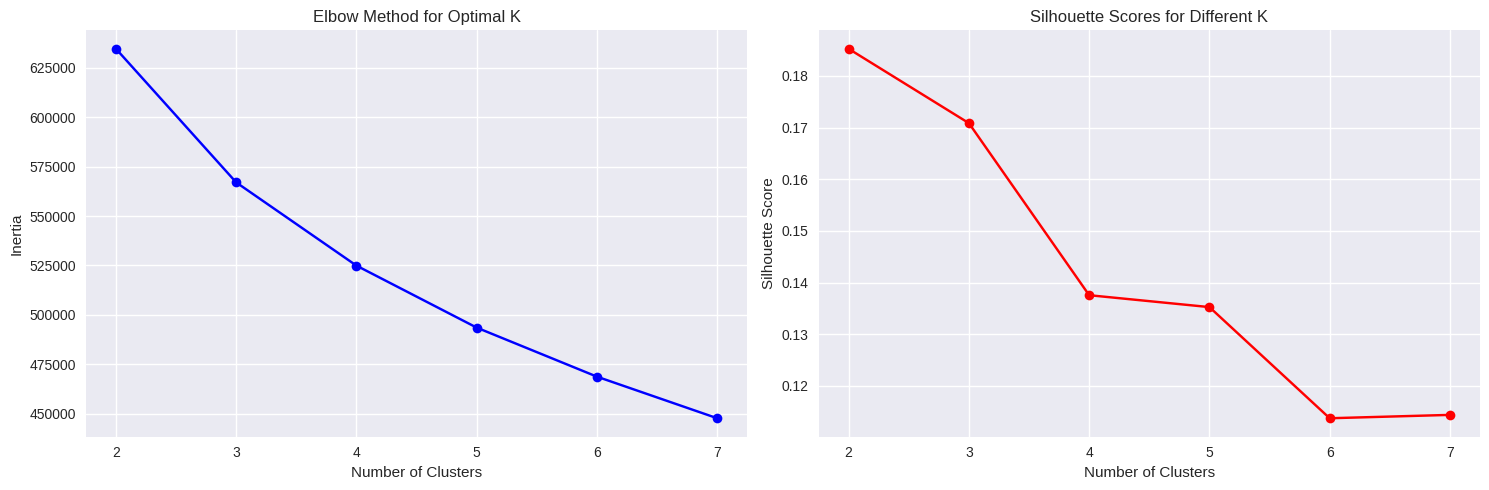

In [39]:
# Plot elbow method and silhouette scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K')

plt.tight_layout()
plt.show()


Optimal number of clusters: 2
Silhouette Score for K-Means: 0.1853


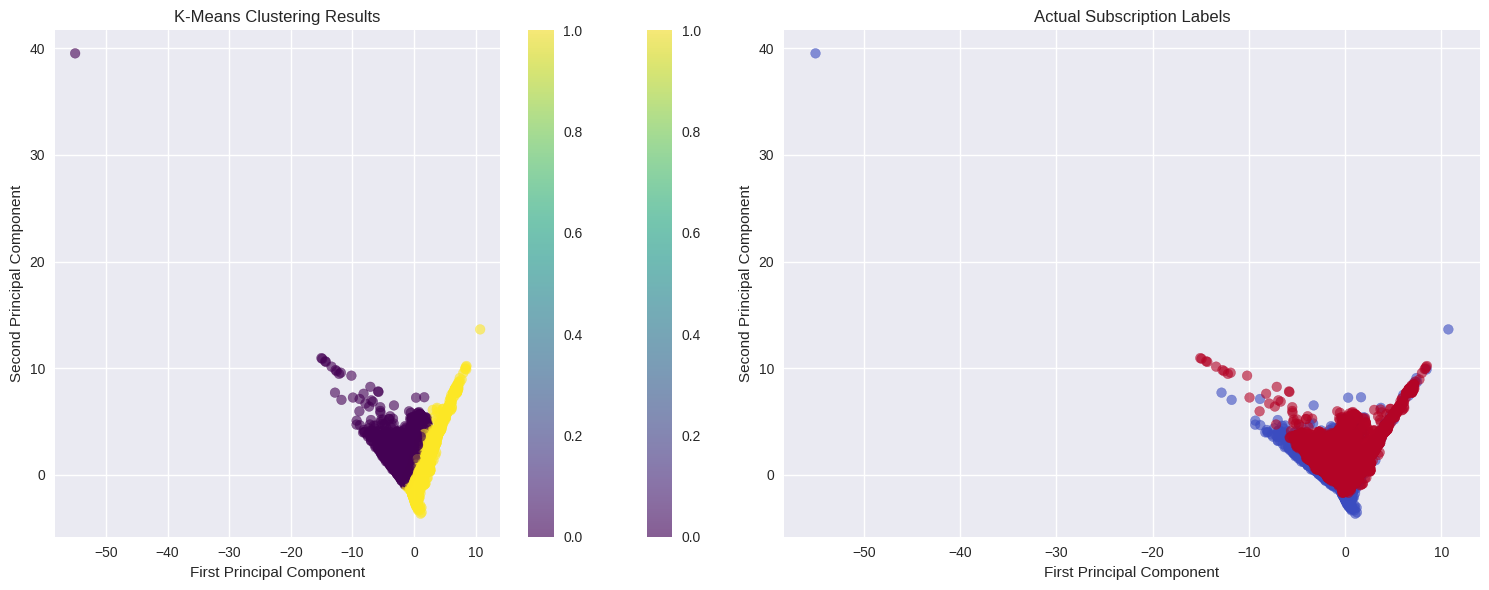

In [40]:

# Apply K-Means with optimal clusters (based on silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train_resampled)

silhouette_avg = silhouette_score(X_train_resampled, clusters)
print(f"Optimal number of clusters: {optimal_k}")
print(f"Silhouette Score for K-Means: {silhouette_avg:.4f}")

# Analyze cluster characteristics
cluster_analysis = pd.DataFrame(X_train_resampled, columns=feature_names)
cluster_analysis['cluster'] = clusters
cluster_analysis['subscription'] = y_train_resampled

# Visualize clusters
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clustering Results')
plt.colorbar(scatter)

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_resampled, cmap='coolwarm', alpha=0.6)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Actual Subscription Labels')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

In [41]:
# Analyze cluster characteristics
print("\nCluster Analysis:")
cluster_summary = cluster_analysis.groupby('cluster').agg({
    'subscription': ['mean', 'count']
}).round(3)
print(cluster_summary)


Cluster Analysis:
        subscription       
                mean  count
cluster                    
0              0.689  15857
1              0.438  48017


In [44]:
# Comprehensive Model Evaluation and Comparison
print("=== COMPREHENSIVE MODEL EVALUATION ===")

# Compare all models
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'Accuracy': result['accuracy'],
        'Precision': result.get('precision', np.nan),
        'Recall': result.get('recall', np.nan),
        'F1-Score': result.get('f1_score', np.nan),
        'ROC-AUC': result.get('roc_auc', np.nan),
        'CV Score': result.get('cv_mean', np.nan)
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
comparison_df.round(4)



=== COMPREHENSIVE MODEL EVALUATION ===

Model Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,CV Score
0,Logistic Regression,0.8319,0.3913,0.7864,0.5226,0.8913,0.8238
1,Random Forest,0.8891,0.5253,0.5397,0.5324,0.8974,0.9398
2,Random Forest Tuned,0.8878,0.5196,0.5397,0.5294,0.8995,NaN


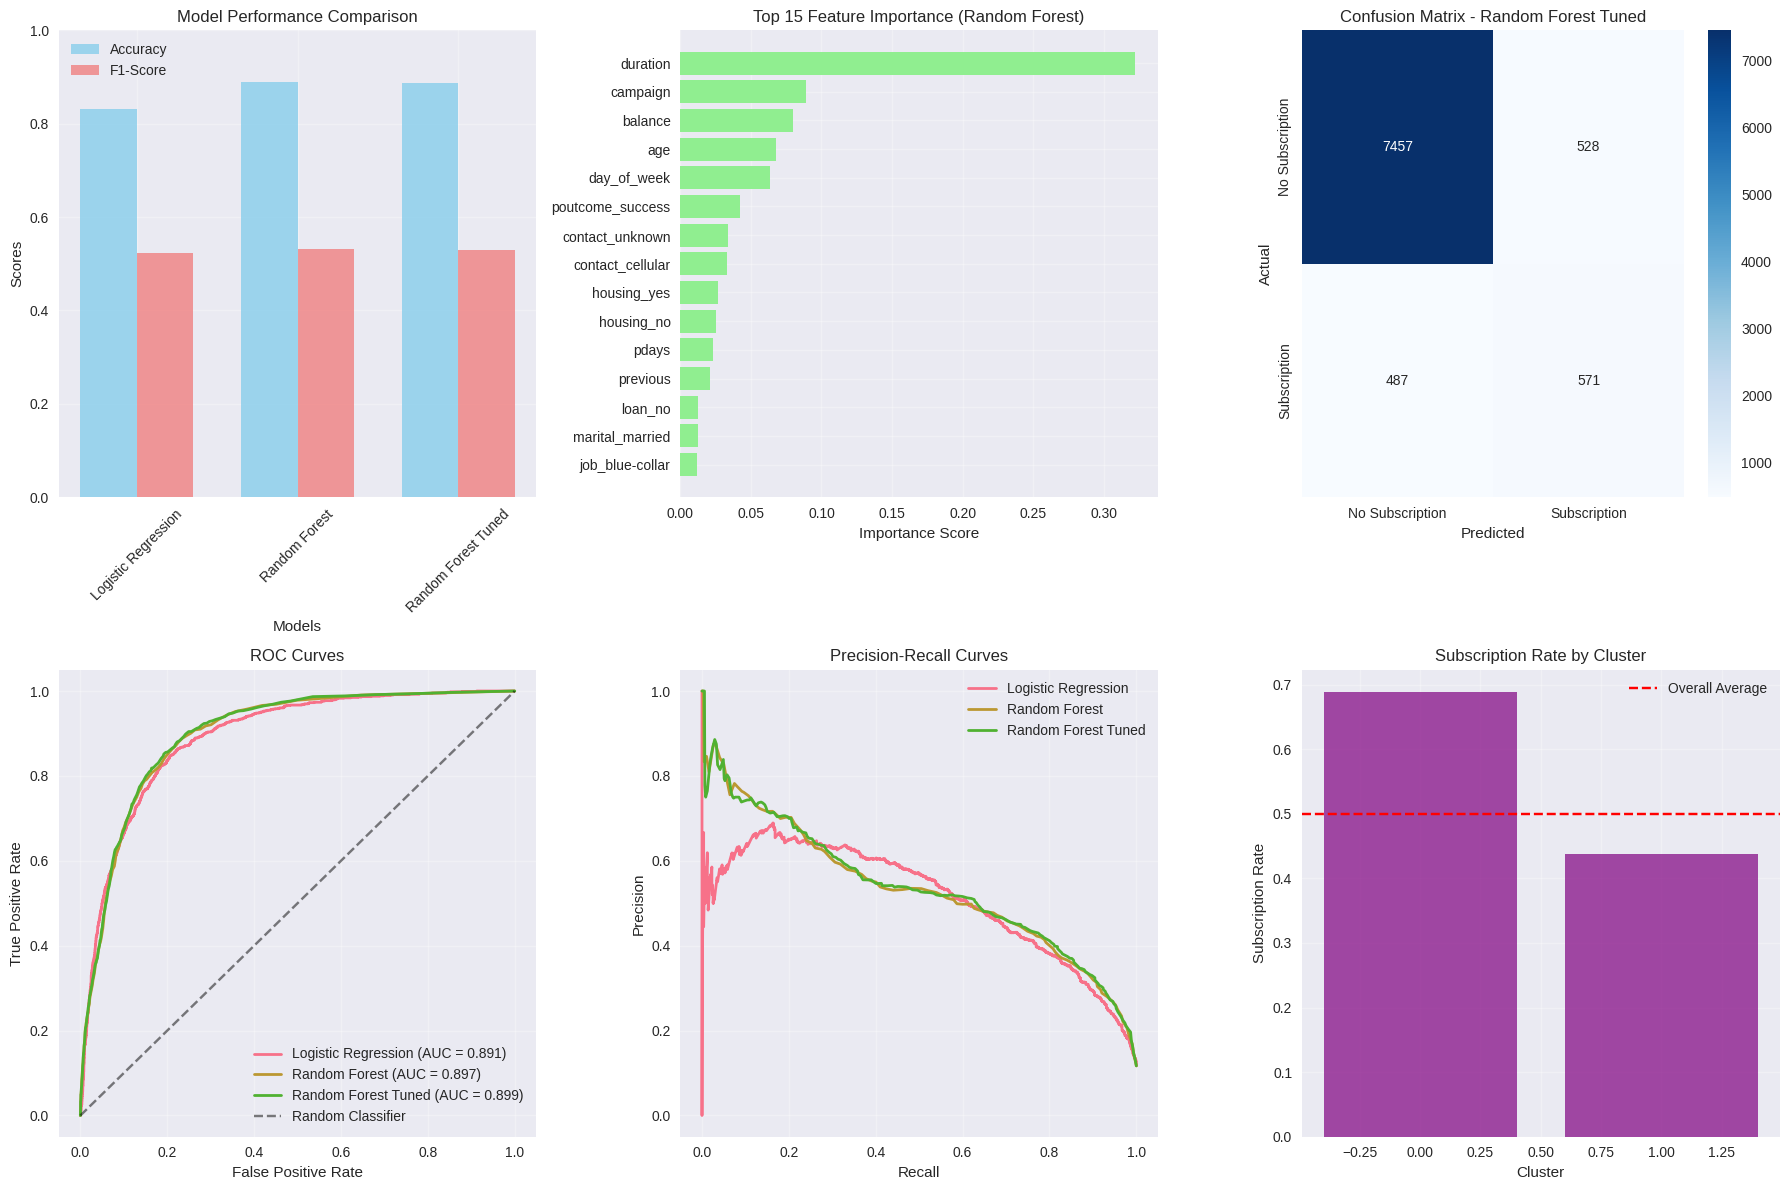

In [46]:
# Visualize model performance
plt.figure(figsize=(18, 12))

# Plot 1: Accuracy and F1-score comparison
plt.subplot(2, 3, 1)
models_compare = ['Logistic Regression', 'Random Forest', 'Random Forest Tuned']
accuracies = [results[model]['accuracy'] for model in models_compare]
f1_scores = [results[model].get('f1_score', 0) for model in models_compare]

x = np.arange(len(models_compare))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='lightcoral')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, models_compare, rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Plot 2: Feature importance from Random Forest
plt.subplot(2, 3, 2)
feature_importance = best_rf.feature_importances_
top_features = 15  # Show top 15 features
sorted_idx = np.argsort(feature_importance)[-top_features:]
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], color='lightgreen')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title(f'Top {top_features} Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.grid(True, alpha=0.3)

# Plot 3: Confusion Matrix for best model
plt.subplot(2, 3, 3)
best_model_name = 'Random Forest Tuned'
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Subscription', 'Subscription'],
            yticklabels=['No Subscription', 'Subscription'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 4: ROC Curves
plt.subplot(2, 3, 4)
for name in ['Logistic Regression', 'Random Forest', 'Random Forest Tuned']:
    if name in results and results[name]['probabilities'] is not None:
        y_proba = results[name]['probabilities']
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Precision-Recall Curves
plt.subplot(2, 3, 5)
for name in ['Logistic Regression', 'Random Forest', 'Random Forest Tuned']:
    if name in results and results[name]['probabilities'] is not None:
        y_proba = results[name]['probabilities']
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall_curve, precision_curve, label=name, linewidth=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Cluster analysis
plt.subplot(2, 3, 6)
cluster_subscription_rate = cluster_analysis.groupby('cluster')['subscription'].mean()
plt.bar(cluster_subscription_rate.index, cluster_subscription_rate.values, color='purple', alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Subscription Rate')
plt.title('Subscription Rate by Cluster')
plt.axhline(y=y_train_resampled.mean(), color='r', linestyle='--', label='Overall Average')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()